# Sunspots Prediction Project

This notebook is part of a **Machine Learning course on Udemy**, created as a **certification project**.  
It focuses on **time-series forecasting of sunspot activity** using **LSTM neural networks**.  

📘 For full project details, theory, and results — see the [README.md](./README.md).


In [1]:
# Importing libraries

import matplotlib.pyplot as plt  #visualization
import seaborn as sns

import pandas as pd #data handling
import numpy as np

import tensorflow as tf #manipulation

import warnings #ignoring warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # suppress TensorFlow warnings/errors
import tensorflow as tf


2025-10-17 15:46:45.502206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760716005.700089      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760716005.757606      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data= pd.read_csv("/kaggle/input/sunspots/Sunspots.csv")
data.head() #first 5 observations

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [3]:
data.tail() #last 5 observations (to check last year in data)

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
3260,3260,2020-09-30,0.6
3261,3261,2020-10-31,14.4
3262,3262,2020-11-30,34.0
3263,3263,2020-12-31,21.8
3264,3264,2021-01-31,10.4


In [4]:
data.info() #general information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3265 non-null   int64  
 1   Date                               3265 non-null   object 
 2   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.7+ KB


* Total records: 3,265 months
* Time span: January 1749 to January 2021
* No null values found in the data

In [5]:
#last column- sunspot numbers
sunspots= data.iloc[:,-1]
sunspots.values

array([ 96.7, 104.3, 116.7, ...,  34. ,  21.8,  10.4])

**Visualizing the data**

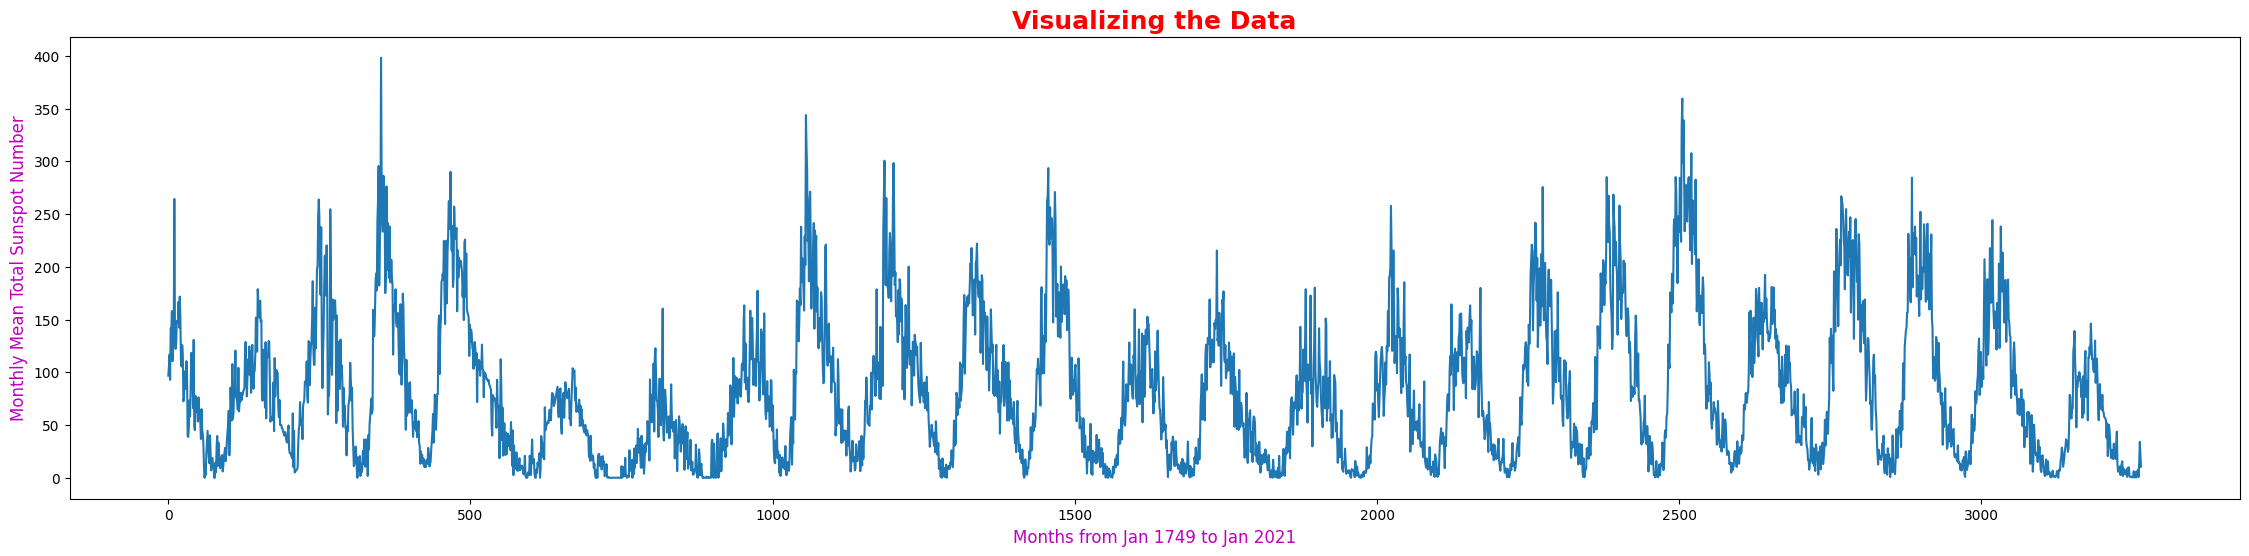

In [6]:
# Visualizing the data - number of sunspots in each month
plt.figure(figsize=(28,6))
plt.plot(sunspots)
plt.ylabel(data.columns[-1], fontsize = 12, color = 'm')
plt.xlabel("Months from Jan 1749 to Jan 2021", fontsize = 12, color = 'm')
plt.title("Visualizing the Data", fontsize = 18, color = 'r', weight = 'bold')
plt.show()

* Each solar cycle lasts around 11 years, which is roughly 132 months.
* The first official solar cycle began in 1755, but this dataset starts from 1749.
* That means there are 6 extra years (about 72 months) of data before the first cycle began.
* In the graph, this early part shows a decline in sunspot numbers, reaching a minimum before the first cycle starts.
* The current solar cycle (Cycle 25) began in December 2019.
* Since this dataset goes up to January 2021, there are about 13 months of data from this current cycle.

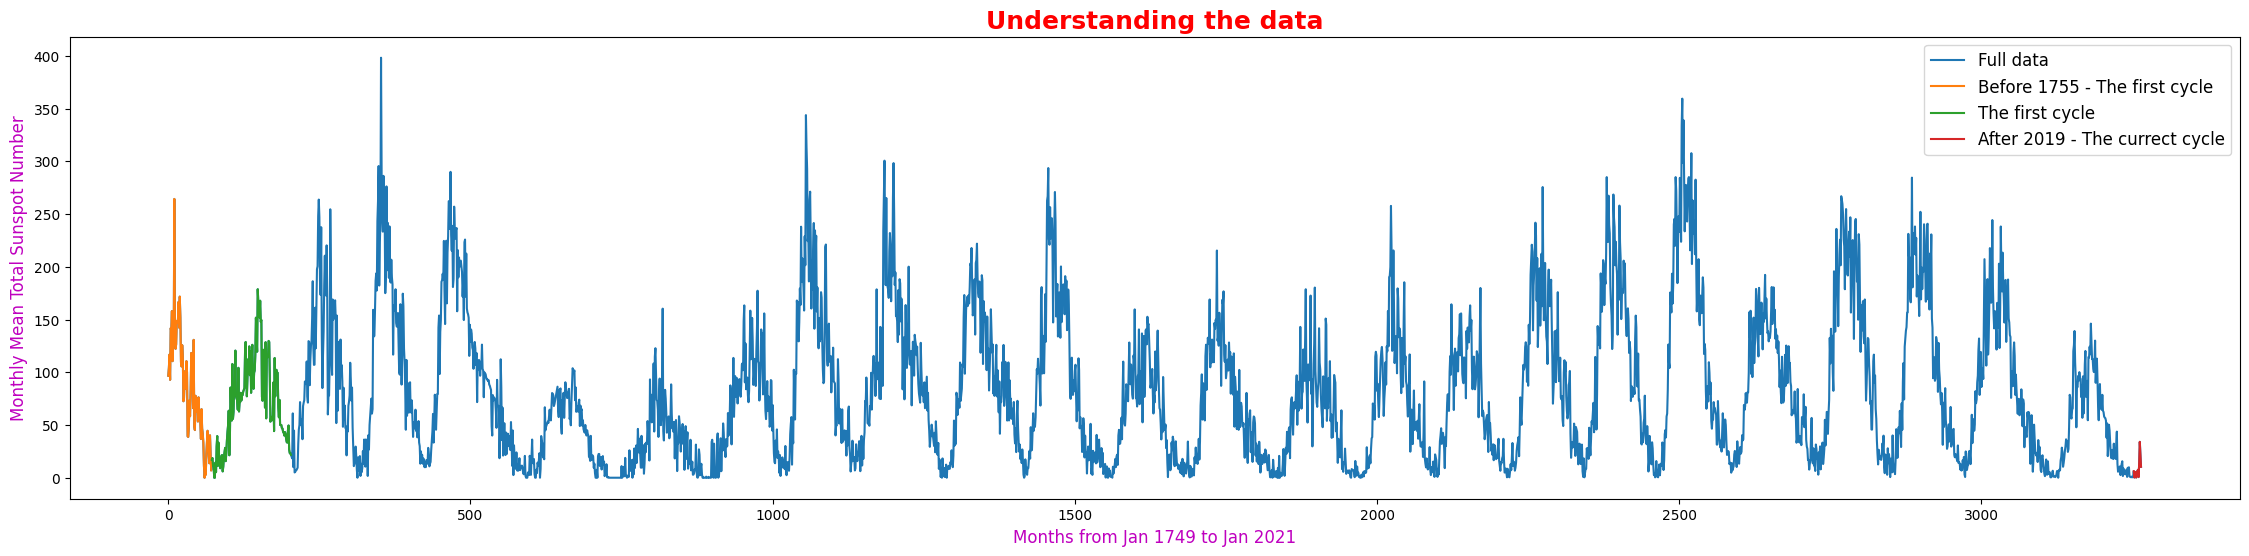

In [7]:
# Highlighting the period before the first cycle, the first cycle, and the current cycle

plt.figure(figsize=(28,6))
plt.plot(sunspots)            # The whole data
plt.plot(sunspots[:72])       # Data from 1749 till the beginning of the first cycle (72 months)
plt.plot(sunspots[72:72+132]) # The first cycle (11 months after the first 72 months)
plt.plot(sunspots[-13:])      # The current cycle
plt.ylabel(data.columns[-1], fontsize = 12, color = 'm')
plt.xlabel("Months from Jan 1749 to Jan 2021", fontsize = 12, color = 'm')
plt.title("Understanding the data", fontsize = 18, color = 'r', weight = 'bold')
plt.legend(["Full data", "Before 1755 - The first cycle", "The first cycle", "After 2019 - The currect cycle"], fontsize = 12)
plt.show()

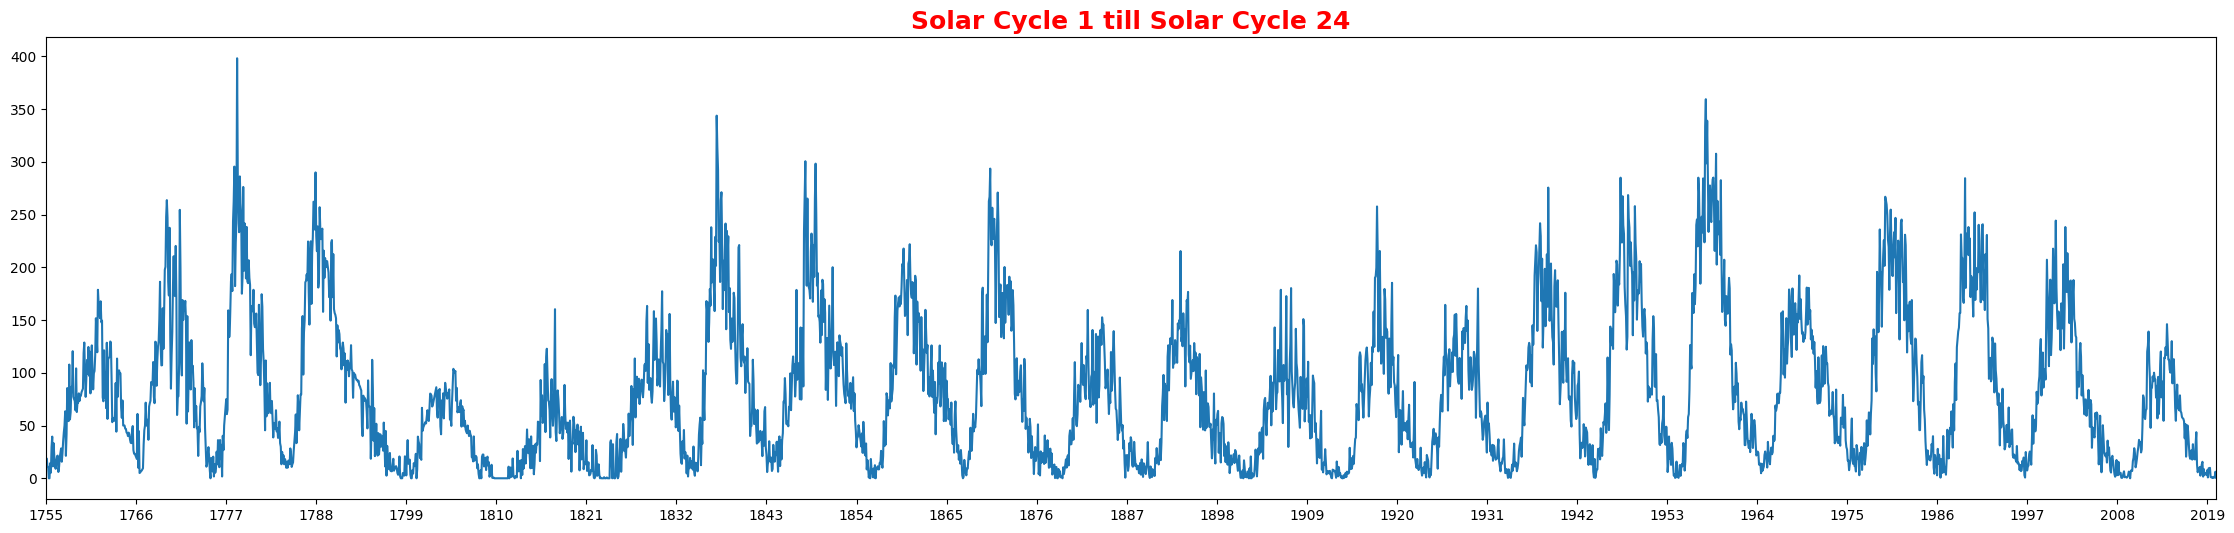

In [8]:
years = []
start = 1755
for i in range(0, len(data.iloc[:,-1][72:]),132):
    years.append(start)
    start+=11

plt.figure(figsize = (28, 6))
plt.plot(sunspots[72:])
plt.title("Solar Cycle 1 till Solar Cycle 24", weight = 'bold', color = 'r', fontsize = 18)
plt.xlim(72, 3265-12)
plt.xticks(range(72, len(sunspots),132))
plt.gca().set_xticklabels(years) # replacing previous limits with calculated years 
plt.show()

* Some parts of the data don’t exactly match the official solar cycle records.
* For example, the 4th solar cycle actually started in 1784, not 1788, and continued until 1798.
* This small difference shows there’s a bit of mismatch between the dataset and historical records.
* The data also looks a little noisy. A few points go as high as 400, even though the highest recorded sunspot count was 285 in March 1958 (Solar Cycle 19).
* Since the data points are arranged in chronological order, this is a time series data.

# **Sequence Models for time series data - RNN, LSTM**

**Preparing functions for generating sequences of data and forecasting - Window method**

In [9]:
dum_series = sunspots[:10].values  # numpy array
dum_series, dum_series.shape       # array and its shape

(array([ 96.7, 104.3, 116.7,  92.8, 141.7, 139.2, 158. , 110.5, 126.5,
        125.8]),
 (10,))

This says that the array is one-dimensional

In [10]:
dum_series=dum_series[:, np.newaxis]   # shape now should be 10x1
dum_series, dum_series.shape           

(array([[ 96.7],
        [104.3],
        [116.7],
        [ 92.8],
        [141.7],
        [139.2],
        [158. ],
        [110.5],
        [126.5],
        [125.8]]),
 (10, 1))

In [11]:
ds = tf.data.Dataset.from_tensor_slices(dum_series)  # Window method of tensorflow won't work on numpy array

# to display the content of the above dataset
for i in ds:
    for val in i:
        print(val)

tf.Tensor(96.7, shape=(), dtype=float64)
tf.Tensor(104.3, shape=(), dtype=float64)
tf.Tensor(116.7, shape=(), dtype=float64)
tf.Tensor(92.8, shape=(), dtype=float64)
tf.Tensor(141.7, shape=(), dtype=float64)
tf.Tensor(139.2, shape=(), dtype=float64)
tf.Tensor(158.0, shape=(), dtype=float64)
tf.Tensor(110.5, shape=(), dtype=float64)
tf.Tensor(126.5, shape=(), dtype=float64)
tf.Tensor(125.8, shape=(), dtype=float64)


I0000 00:00:1760716020.056169      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


For the window method of tensorflow, to generate the sequence of LSTM, tensors are generated from numpy arrays.

In [12]:
# Generating sequence of length 3
window_size = 3                                               
ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # drop remainder if True ensures the same shape of the tensor

for i in ds:
    for val in i:
        print(val)

tf.Tensor([96.7], shape=(1,), dtype=float64)
tf.Tensor([104.3], shape=(1,), dtype=float64)
tf.Tensor([116.7], shape=(1,), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor([104.3], shape=(1,), dtype=float64)
tf.Tensor([116.7], shape=(1,), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor([116.7], shape=(1,), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor([158.], shape=(1,), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor([158.], shape=(1,), dtype=float64)
tf.Tensor([110.5], shape=(1,), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor([158.], shape=(1,), dtype=float

For example, Previous 3 values will be used to train the model to learn and predict the 4th value.

In [13]:
ds = ds.flat_map(lambda w: w.batch(window_size + 1)) # batch of 4 is generated
ds = ds.map(lambda w: (w[:-1], w[-1]))               # two different outputs are generated (3 and 1)

for i in ds:
    for val in i:
        print(val)

tf.Tensor(
[[ 96.7]
 [104.3]
 [116.7]], shape=(3, 1), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor(
[[104.3]
 [116.7]
 [ 92.8]], shape=(3, 1), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor(
[[116.7]
 [ 92.8]
 [141.7]], shape=(3, 1), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor(
[[ 92.8]
 [141.7]
 [139.2]], shape=(3, 1), dtype=float64)
tf.Tensor([158.], shape=(1,), dtype=float64)
tf.Tensor(
[[141.7]
 [139.2]
 [158. ]], shape=(3, 1), dtype=float64)
tf.Tensor([110.5], shape=(1,), dtype=float64)
tf.Tensor(
[[139.2]
 [158. ]
 [110.5]], shape=(3, 1), dtype=float64)
tf.Tensor([126.5], shape=(1,), dtype=float64)
tf.Tensor(
[[158. ]
 [110.5]
 [126.5]], shape=(3, 1), dtype=float64)
tf.Tensor([125.8], shape=(1,), dtype=float64)


Batches of 4 are generated (3 input data and one predicted value)

In [14]:
ds = ds.batch(10).prefetch(1)  

for i in ds:
    for val in i:
        print(val)
    print("\n")

tf.Tensor(
[[[ 96.7]
  [104.3]
  [116.7]]

 [[104.3]
  [116.7]
  [ 92.8]]

 [[116.7]
  [ 92.8]
  [141.7]]

 [[ 92.8]
  [141.7]
  [139.2]]

 [[141.7]
  [139.2]
  [158. ]]

 [[139.2]
  [158. ]
  [110.5]]

 [[158. ]
  [110.5]
  [126.5]]], shape=(7, 3, 1), dtype=float64)
tf.Tensor(
[[ 92.8]
 [141.7]
 [139.2]
 [158. ]
 [110.5]
 [126.5]
 [125.8]], shape=(7, 1), dtype=float64)




* This is the final 3D data with sequence length of 3.
* Since there are 10 elements, maximum batch size is 7.
* Also, shape(7,3,1) implies shape(batch size, sequence length, features using which the prediction takes place)

In [15]:
#compiling all the generating functions defined above to train the helper fucntion
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = series[:, np.newaxis]                                # adding new axis(dimension) to array
    ds = tf.data.Dataset.from_tensor_slices(series)               # converting numpy array to tensor in order to use window of tensor flow
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # creating window
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))          # flattening batches as datasets of their elements (input elements)
    ds = ds.shuffle(shuffle_buffer)                               # to reduce the variance and overfits
    ds = ds.map(lambda w: (w[:-1], w[-1]))                        # now this window has the input value from which the future value has to be predicted followed by the future value
    return ds.batch(batch_size).prefetch(1)                       # prefetching one batch of data, also makes sure one batch is ready next

In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)  # to predict
    return forecast

Here, window size does not include a +1 because this model is going to be trained to predict the next value.

In [17]:
#data preparation
series = data['Monthly Mean Total Sunspot Number'].values
time = data['Unnamed: 0'].values

# splitting the data into train and test
split_time = int(len(series)*0.9)          # 90% of the original data is for training
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
print(f"There are {len(x_train)} training samples and {len(x_valid)} validation samples.")

# Parameters
delta = 1                      # Huber loss
window_size = 60              
batch_size = 145              
shuffle_buffer_size= 900       # shuffling the dataset randomly
epochs = 100                   # for optimal learning rate
train_epochs = epochs + 100    # training epochs
momentum_sgd = 0.9             # for optimizer

There are 2938 training samples and 327 validation samples.


* Here, as an example, 90% of the original data is used as training sample which will be used to predict the remaining values.
The values predicted will be validated by the validation samples(remaining 10%)
* Hubber loss is chosen since it is less sensitive to outliers in the data.

**Building the model and finding the best learning rate to optimize model training**

In [18]:
#clearing previous model data
tf.keras.backend.clear_session()

# to make sure results are same everytime the notebook is run
tf.random.set_seed(42)
np.random.seed(42)

# calling the window_dataset function to generate the training data
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# model
model = tf.keras.models.Sequential([
#a stack of layers
  tf.keras.layers.Conv1D(filters=132, kernel_size=4,strides=1, padding="causal", activation="relu",input_shape=[None, 1]), #smoothens the input (noise reduction)
  tf.keras.layers.LSTM(256, return_sequences=True), # returns output for all cycles
  tf.keras.layers.LSTM(132, return_sequences=False),# reutrns output only the last time
  tf.keras.layers.Dense(80, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1), # outputs go through all these dense layers those many times and final output is predicted
  tf.keras.layers.Lambda(lambda x: x * 400) #to scale the data back into the same range as the real data (from visulaized data)
])

model.summary()

#it changes the learning rate gradually during training to see what works best.
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20), verbose = 0) #  starting lr * 10^(0/20), starting lr * 10^(1/20), so on..

# using Stochastic Gradient Desect (STG) as the optimizer tells TensorFlow how to train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=momentum_sgd) #updates weights slowly, based on small batches of data
model.compile(loss=tf.keras.losses.Huber(delta),
              optimizer=optimizer,
              metrics=["mae"]) # applying Huber loss

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 132)      │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 256)      │       398,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 132)            │       205,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │        10,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 615,849 (2.35 MB)

 Trainable params: 615,849 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(train_set, epochs=epochs, callbacks=[lr_schedule]) # to track the history of training

Epoch 1/100


I0000 00:00:1760716026.630896      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 167.3176 - mae: 167.8176 - learning_rate: 1.0000e-08
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 107.7198 - mae: 108.2195 - learning_rate: 1.1220e-08
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 81.7750 - mae: 82.2747 - learning_rate: 1.2589e-08
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 60.3974 - mae: 60.8958 - learning_rate: 1.4125e-08
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 47.4423 - mae: 47.9388 - learning_rate: 1.5849e-08
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 39.8416 - mae: 40.3379 - learning_rate: 1.7783e-08
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 36.6277 - mae: 37.1254 - learning_rate: 1.9953e-08
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 34.2107 - mae: 34.7081 - learning_rate: 2.2387e-08
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 32.7923 - mae: 33.2891 - learning_rate: 2.5119e-08
Epoch 10/

In [20]:
# learning rates used above
lrs = 1e-8 * (10**(np.arange(epochs)/20))
lrs

array([1.00000000e-08, 1.12201845e-08, 1.25892541e-08, 1.41253754e-08,
       1.58489319e-08, 1.77827941e-08, 1.99526231e-08, 2.23872114e-08,
       2.51188643e-08, 2.81838293e-08, 3.16227766e-08, 3.54813389e-08,
       3.98107171e-08, 4.46683592e-08, 5.01187234e-08, 5.62341325e-08,
       6.30957344e-08, 7.07945784e-08, 7.94328235e-08, 8.91250938e-08,
       1.00000000e-07, 1.12201845e-07, 1.25892541e-07, 1.41253754e-07,
       1.58489319e-07, 1.77827941e-07, 1.99526231e-07, 2.23872114e-07,
       2.51188643e-07, 2.81838293e-07, 3.16227766e-07, 3.54813389e-07,
       3.98107171e-07, 4.46683592e-07, 5.01187234e-07, 5.62341325e-07,
       6.30957344e-07, 7.07945784e-07, 7.94328235e-07, 8.91250938e-07,
       1.00000000e-06, 1.12201845e-06, 1.25892541e-06, 1.41253754e-06,
       1.58489319e-06, 1.77827941e-06, 1.99526231e-06, 2.23872114e-06,
       2.51188643e-06, 2.81838293e-06, 3.16227766e-06, 3.54813389e-06,
       3.98107171e-06, 4.46683592e-06, 5.01187234e-06, 5.62341325e-06,
      

In [21]:
# to find the optimal learning rate
min_loss = min(history.history['loss']) #minimum loss
idx_min_loss = history.history['loss'].index(min_loss) #index of minimum loss
opt_lr = lrs[idx_min_loss] # learning rate corresponding to minimum loss
first = str(round(float(str(opt_lr).split('e')[0]))) #rounding off lr
second = str(opt_lr).split('e')[-1]
final = [first, second]
x = "e".join(final)
x = float(x)
print(f"Optimal Learning Rate was {x}.")

Optimal Learning Rate was 2e-06.


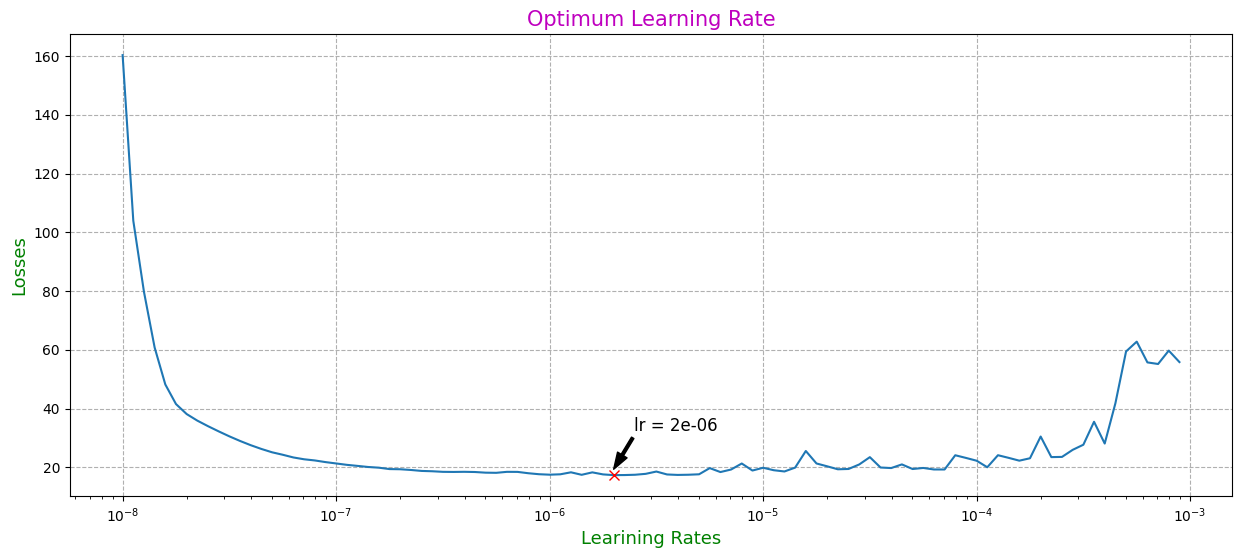

In [22]:
# plotting Losses vs Learning Rates
fig = plt.figure(figsize=(15, 6))
plt.semilogx(lrs, history.history["loss"]) #learning rates increase exponentially. So, plotting them on a logarithmic scale gives a clear curve.
plt.grid(True, ls="--")
plt.plot(opt_lr,min_loss, color = 'r', marker = 'x', markersize = 7)
plt.title(f"Optimum Learning Rate", color = 'm', fontsize = 15)
plt.ylabel("Losses", fontsize = 13, color = 'g')
plt.xlabel("Learining Rates", fontsize = 13, color = 'g')
plt.annotate(f"lr = {x}", (opt_lr,min_loss+2), (opt_lr+0.05e-5, min_loss+15), arrowprops = dict(facecolor ='k', width = 2, headwidth = 8), fontsize = 12) #highlighting the best lr on the graph
plt.show()

In [23]:
# Using the same steps to build the model but now with the optimal learning rate to train it
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=132, kernel_size=4,strides=1, padding="causal", activation="relu",input_shape=[None, 1]),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(132, return_sequences=False),
  tf.keras.layers.Dense(80, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=opt_lr, momentum=momentum_sgd)
model.compile(loss=tf.keras.losses.Huber(delta),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=train_epochs)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 54.9024 - mae: 55.4006
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 24.1194 - mae: 24.6142
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 20.8867 - mae: 21.3798
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 20.3223 - mae: 20.8152
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 19.3079 - mae: 19.8012
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 18.4839 - mae: 18.9759
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 18.2732 - mae: 18.7667
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 18.8200 - mae: 19.3113
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 18.6142 - mae: 19.1078
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 18.0020 - mae: 18.4932
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 18.2985 - mae: 18.7898
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 18.1204 - mae: 18.6105
E

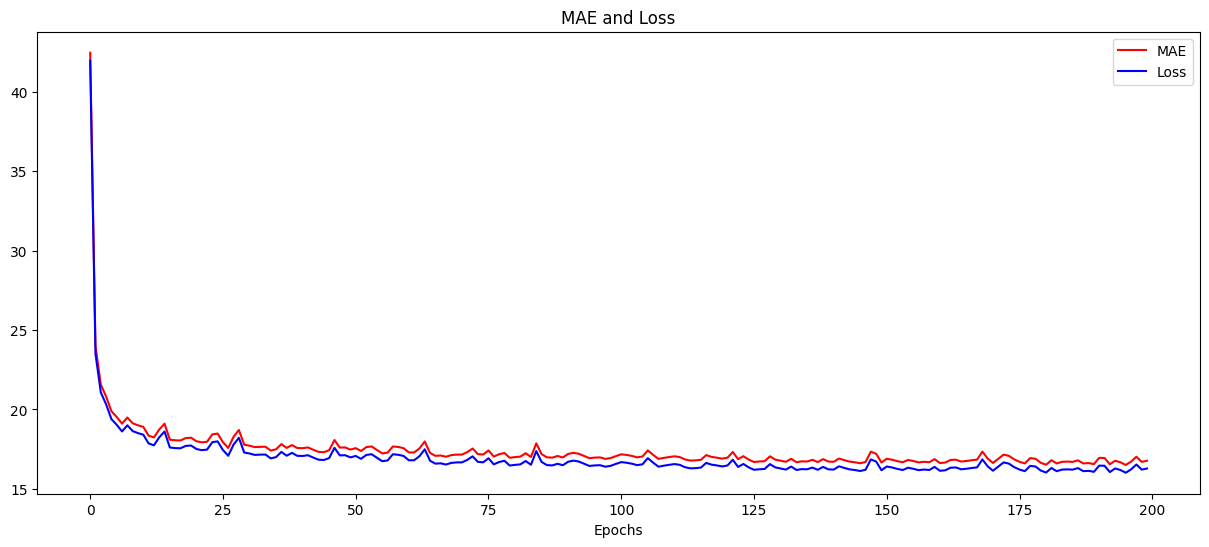

In [24]:
# fetching the MAE and Huber Loss from the history
mae=history.history['mae']
loss=history.history['loss']

# plotting
fig = plt.figure(figsize=(15, 6))
plt.plot(mae, 'r')
plt.plot(loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.legend(["MAE", "Loss"])

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


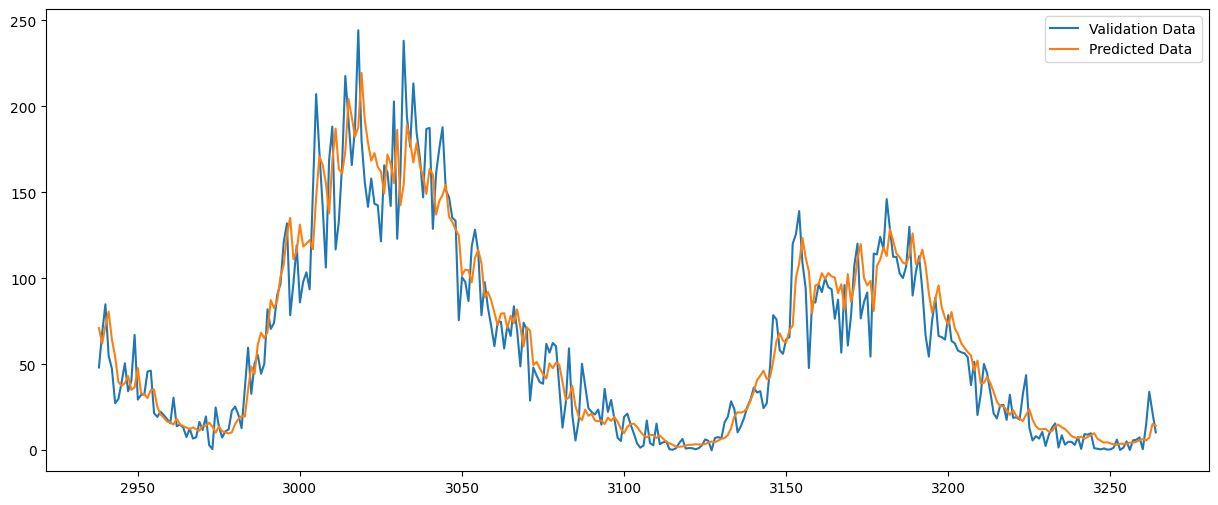

In [25]:
#calling the function 
rnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, 0]  # rnn_forecast[-328:-1, 0]

# plotting original data vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forecast)
plt.title("")
plt.legend(["Validation Data", "Predicted Data"])
plt.show()

In [26]:
# validation MAE
val_mae=tf.keras.metrics.mae(x_valid, rnn_forecast).numpy()
print(f"MAE on the validation data:- {val_mae}")

MAE on the validation data:- 12.807442665100098


# **-------------------------------------------------------------------------------------**